In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitterdata/finalSentimentdata2.csv


## Import Statements

In [2]:
# Imports statements.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

#Data Preprocessing and Feature Engineering
from wordcloud import WordCloud, STOPWORDS 
from gensim.parsing.preprocessing import remove_stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
%matplotlib inline

## Getting Insight about the data

In [3]:
def display_all_details(dataframe):
    print(('='*50)+'DATA'+('='*50))
    print(('-'*50)+'SHAPE'+('-'*50))
    print(dataframe.shape)
    print(('-'*50)+'COLUMNS'+('-'*50))
    print(dataframe.columns)
    print(('-'*50)+'DESCRIBE'+('-'*50))
    print(dataframe.describe())
    print(('-'*50)+'INFO'+('-'*50))
    print(dataframe.info())
    print(('='*50)+'===='+('='*50))

In [4]:
twitter_data = pd.read_csv('../input/twitterdata/finalSentimentdata2.csv')

In [5]:
display_all_details(twitter_data)

==================================================DATA==================================================
--------------------------------------------------SHAPE--------------------------------------------------
(3090, 3)
--------------------------------------------------COLUMNS--------------------------------------------------
Index(['Unnamed: 0', 'sentiment', 'text'], dtype='object')
--------------------------------------------------DESCRIBE--------------------------------------------------
        Unnamed: 0
count  3090.000000
mean   2689.072816
std    1438.624297
min       3.000000
25%    1368.250000
50%    3030.500000
75%    3949.750000
max    4722.000000
--------------------------------------------------INFO--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3090 entries, 0 to 3089
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3090 non-null   int64 
 

In [6]:
twitter_data.head()

,Unnamed: 0,sentiment,text
0,3204,sad,agree the poor in india are treated badly thei...
1,1431,joy,if only i could have spent the with this cutie...
2,654,joy,will nature conservation remain a priority in ...
3,2530,sad,coronavirus disappearing in italy show this to...
4,2296,sad,uk records lowest daily virus death toll since...


In [7]:
twitter_data.tail()

,Unnamed: 0,sentiment,text
3085,2579,sad,today at 02 30pm a 54 year old bangladeshi mal...
3086,3579,anger,corona virus i implore that you cease activity...
3087,221,joy,issa date once lockdown ends inshaallah (and c...
3088,2705,sad,the death toll due to covid 19 rose to 31 in j...
3089,2962,sad,the rates are become barrier for poor people t...


In [8]:
# Checking missing values columns
twitter_data.isnull().sum()

Unnamed: 0    0
sentiment     0
text          0
dtype: int64

In [9]:
print(twitter_data.sentiment.value_counts())


fear     801
sad      795
anger    767
joy      727
Name: sentiment, dtype: int64


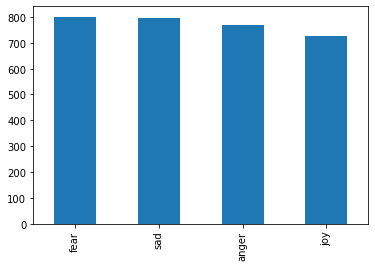

In [10]:
twitter_data.sentiment.value_counts().plot(kind = 'bar')

In [11]:
# Creating a mapping for sentiments
mapping = {'fear':0,
          'sad':1,
          'anger':2,
          'joy':3}

In [12]:
twitter_data['sentiment'] = twitter_data['sentiment'].map(mapping)

In [13]:
twitter_data.head()

,Unnamed: 0,sentiment,text
0,3204,1,agree the poor in india are treated badly thei...
1,1431,3,if only i could have spent the with this cutie...
2,654,3,will nature conservation remain a priority in ...
3,2530,1,coronavirus disappearing in italy show this to...
4,2296,1,uk records lowest daily virus death toll since...


In [14]:
for tweet in twitter_data.text.head(20):
    print(tweet)

agree the poor in india are treated badly their poors seek a living in singapore and are treated like citizens they are given free medical treatment given food daily sim cards to call home to tell their family that they are fine if covid 19 case treated foc in hospitals
if only i could have spent the with this cutie vc sakshi__s i n g h coast crossing republik …
will nature conservation remain a priority in post corona bangladesh | the daily star
coronavirus disappearing in italy show this to "intellectuals" who say lockdowns do not work …
uk records lowest daily virus death toll since start of lockdown govt
joe biden's coronavirus web address lands on a donation page for his campaign he is profiting from fear demopos
respected sir in our telangana all private teachers and lecturers are in horrible situations due to covid 19 and mainly private management (chaithanya nd narayana) b'caz they told to all faculty's like “no work no pay “ so pls take the action nd save their life's
so is al

In [15]:
def clean_text_column(row):
    text = row['text'].lower()
    text = re.sub(r'[^(a-zA-Z\s)]','',text)
    text = re.sub(r'\(','',text)
    text = re.sub(r'\)','',text)
    text = text.replace('\n',' ')
    text = text.strip()
    return text

In [16]:
twitter_data['cleaned_text'] = twitter_data.apply(clean_text_column,axis = 1)

In [17]:
twitter_data.head()

,Unnamed: 0,sentiment,text,cleaned_text
0,3204,1,agree the poor in india are treated badly thei...,agree the poor in india are treated badly thei...
1,1431,3,if only i could have spent the with this cutie...,if only i could have spent the with this cutie...
2,654,3,will nature conservation remain a priority in ...,will nature conservation remain a priority in ...
3,2530,1,coronavirus disappearing in italy show this to...,coronavirus disappearing in italy show this to...
4,2296,1,uk records lowest daily virus death toll since...,uk records lowest daily virus death toll since...


In [18]:
# These are new stopwords which i add after several model runs and found out these are irrelevant words which are created which cleaning process.
new_additions=['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn']

## Creating a WordCloud to visualize most frequent words

In [19]:
new_string = ''
stopwords = set(list(STOPWORDS)+new_additions)
for val in twitter_data.cleaned_text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    new_string += " ".join(tokens)+" "

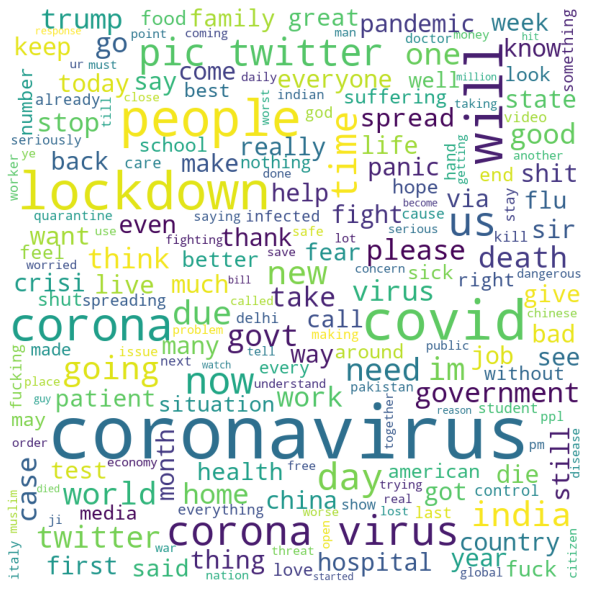

In [20]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(new_string) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### This seems good and gives a good picture of words frequency in dataset

In [21]:
# Check for spaced entry which can be created due to cleaning step.
twitter_data.cleaned_text.str.isspace().sum()

0

## Stopword removal

In [22]:
filtered_sentences = []
for tweet in twitter_data.cleaned_text:
    filtered_sentences.append(remove_stopwords(tweet))

In [23]:
filter_sentence_df = pd.DataFrame(filtered_sentences,columns = ['filter_sentence'])

In [24]:
new_twitter_data = pd.concat([twitter_data,filter_sentence_df],axis = 1)

In [25]:
new_twitter_data.head()

,Unnamed: 0,sentiment,text,cleaned_text,filter_sentence
0,3204,1,agree the poor in india are treated badly thei...,agree the poor in india are treated badly thei...,agree poor india treated badly poors seek livi...
1,1431,3,if only i could have spent the with this cutie...,if only i could have spent the with this cutie...,spent cutie vc sakshis n g h coast crossing re...
2,654,3,will nature conservation remain a priority in ...,will nature conservation remain a priority in ...,nature conservation remain priority post coron...
3,2530,1,coronavirus disappearing in italy show this to...,coronavirus disappearing in italy show this to...,coronavirus disappearing italy intellectuals l...
4,2296,1,uk records lowest daily virus death toll since...,uk records lowest daily virus death toll since...,uk records lowest daily virus death toll start...


In [26]:
#Normalizing the words in tweets 
def normalization(tweet):
    lem = WordNetLemmatizer()
    normalized_tweet = []
    for word in tweet['filter_sentence'].split():
        normalized_text = lem.lemmatize(word,'v')
        normalized_tweet.append(normalized_text)
    return normalized_tweet

In [27]:
new_twitter_data['normalised_tweet'] = new_twitter_data.apply(normalization,axis = 1)

In [28]:
new_twitter_data.head()

,Unnamed: 0,sentiment,text,cleaned_text,filter_sentence,normalised_tweet
0,3204,1,agree the poor in india are treated badly thei...,agree the poor in india are treated badly thei...,agree poor india treated badly poors seek livi...,"[agree, poor, india, treat, badly, poors, seek..."
1,1431,3,if only i could have spent the with this cutie...,if only i could have spent the with this cutie...,spent cutie vc sakshis n g h coast crossing re...,"[spend, cutie, vc, sakshis, n, g, h, coast, cr..."
2,654,3,will nature conservation remain a priority in ...,will nature conservation remain a priority in ...,nature conservation remain priority post coron...,"[nature, conservation, remain, priority, post,..."
3,2530,1,coronavirus disappearing in italy show this to...,coronavirus disappearing in italy show this to...,coronavirus disappearing italy intellectuals l...,"[coronavirus, disappear, italy, intellectuals,..."
4,2296,1,uk records lowest daily virus death toll since...,uk records lowest daily virus death toll since...,uk records lowest daily virus death toll start...,"[uk, record, lowest, daily, virus, death, toll..."


In [29]:
msg_train, msg_test, label_train, label_test = train_test_split(new_twitter_data['filter_sentence'],new_twitter_data['sentiment'], test_size=0.1,random_state = 2)

## MultinomialNB Pipeline

In [30]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
    ])

In [31]:
pipeline.fit(msg_train,label_train)
predictions = pipeline.predict(msg_test)
print(classification_report(predictions,label_test))
print(confusion_matrix(predictions,label_test))
print(accuracy_score(predictions,label_test))

              precision    recall  f1-score   support

           0       0.82      0.61      0.70       102
           1       0.86      0.72      0.78       103
           2       0.44      0.76      0.56        46
           3       0.76      0.88      0.82        58

    accuracy                           0.72       309
   macro avg       0.72      0.74      0.71       309
weighted avg       0.76      0.72      0.73       309

[[62  5 34  1]
 [ 6 74  9 14]
 [ 6  4 35  1]
 [ 2  3  2 51]]
0.7184466019417476


## Logistic Regression pipeline

In [32]:
pipeline2 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('classifier',LogisticRegression(solver='sag')),  # train on TF-IDF vectors w/ Naive Bayes classifier
    ])

In [33]:
pipeline2.fit(msg_train,label_train)
predictions2 = pipeline2.predict(msg_test)
print(classification_report(predictions2,label_test))
print(confusion_matrix(predictions2,label_test))
print(accuracy_score(predictions2,label_test))

              precision    recall  f1-score   support

           0       0.79      0.67      0.72        90
           1       0.81      0.81      0.81        86
           2       0.60      0.75      0.67        64
           3       0.81      0.78      0.79        69

    accuracy                           0.75       309
   macro avg       0.75      0.75      0.75       309
weighted avg       0.76      0.75      0.75       309

[[60  3 25  2]
 [ 3 70  3 10]
 [10  5 48  1]
 [ 3  8  4 54]]
0.7508090614886731


## Support Vector Machine pipeline

In [34]:
pipeline3 = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stopwords)),
                ('clf', OneVsRestClassifier(SVC(), n_jobs=1)),
            ])

In [35]:
pipeline3.fit(msg_train,label_train)
predictions3 = pipeline3.predict(msg_test)
print(classification_report(predictions3,label_test))
print(confusion_matrix(predictions3,label_test))
print(accuracy_score(predictions3,label_test))

              precision    recall  f1-score   support

           0       0.76      0.66      0.71        88
           1       0.85      0.81      0.83        90
           2       0.55      0.73      0.63        60
           3       0.84      0.79      0.81        71

    accuracy                           0.75       309
   macro avg       0.75      0.75      0.74       309
weighted avg       0.76      0.75      0.75       309

[[58  2 27  1]
 [ 3 73  4 10]
 [12  4 44  0]
 [ 3  7  5 56]]
0.7475728155339806


## Voting Classifier pipeline

In [36]:
from sklearn.ensemble import VotingClassifier

In [37]:
voting_classifier = VotingClassifier(estimators=[ ('nb', pipeline),('lr', pipeline2), ('svc', pipeline3)], voting='hard')

In [38]:
voting_classifier.fit(msg_train,label_train)
predictions4 = voting_classifier.predict(msg_test)
print(classification_report(predictions4,label_test))
print(confusion_matrix(predictions4,label_test))
print(accuracy_score(predictions4,label_test))

              precision    recall  f1-score   support

           0       0.79      0.65      0.71        92
           1       0.84      0.81      0.82        89
           2       0.56      0.76      0.65        59
           3       0.82      0.80      0.81        69

    accuracy                           0.75       309
   macro avg       0.75      0.76      0.75       309
weighted avg       0.77      0.75      0.75       309

[[60  3 28  1]
 [ 3 72  3 11]
 [10  4 45  0]
 [ 3  7  4 55]]
0.7508090614886731


# Let's Try LSTM

In [39]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

In [40]:
new_twitter_data.head()

,Unnamed: 0,sentiment,text,cleaned_text,filter_sentence,normalised_tweet
0,3204,1,agree the poor in india are treated badly thei...,agree the poor in india are treated badly thei...,agree poor india treated badly poors seek livi...,"[agree, poor, india, treat, badly, poors, seek..."
1,1431,3,if only i could have spent the with this cutie...,if only i could have spent the with this cutie...,spent cutie vc sakshis n g h coast crossing re...,"[spend, cutie, vc, sakshis, n, g, h, coast, cr..."
2,654,3,will nature conservation remain a priority in ...,will nature conservation remain a priority in ...,nature conservation remain priority post coron...,"[nature, conservation, remain, priority, post,..."
3,2530,1,coronavirus disappearing in italy show this to...,coronavirus disappearing in italy show this to...,coronavirus disappearing italy intellectuals l...,"[coronavirus, disappear, italy, intellectuals,..."
4,2296,1,uk records lowest daily virus death toll since...,uk records lowest daily virus death toll since...,uk records lowest daily virus death toll start...,"[uk, record, lowest, daily, virus, death, toll..."


In [41]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 1000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(new_twitter_data.filter_sentence.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9810 unique tokens.


In [42]:
X = tokenizer.texts_to_sequences(new_twitter_data.filter_sentence.values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (3090, 250)


In [43]:
Y = pd.get_dummies(new_twitter_data.sentiment).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (3090, 4)


In [44]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 2)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2472, 250) (2472, 4)
(618, 250) (618, 4)


In [45]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.1))
model.add(LSTM(100, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          100000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 4)                 404       
Total params: 180,804
Trainable params: 180,804
Non-trainable params: 0
_________________________________________________________________
None


In [46]:
epochs = 20
batch_size = 64
# I am using EarlyStopping to monitor val_loss upto 3 patience level to prevent the model from overfitting.
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/20
35/35 [==============================] - 19s 544ms/step - loss: 1.3517 - accuracy: 0.3867 - val_loss: 1.2528 - val_accuracy: 0.4960
Epoch 2/20
35/35 [==============================] - 18s 521ms/step - loss: 1.1456 - accuracy: 0.5175 - val_loss: 1.0798 - val_accuracy: 0.5605
Epoch 3/20
35/35 [==============================] - 18s 527ms/step - loss: 0.9286 - accuracy: 0.6196 - val_loss: 0.9348 - val_accuracy: 0.5766
Epoch 4/20
35/35 [==============================] - 19s 529ms/step - loss: 0.7590 - accuracy: 0.6906 - val_loss: 0.8813 - val_accuracy: 0.6169
Epoch 5/20
35/35 [==============================] - 18s 513ms/step - loss: 0.6390 - accuracy: 0.7536 - val_loss: 0.9115 - val_accuracy: 0.6169
Epoch 6/20
35/35 [==============================] - 18s 512ms/step - loss: 0.5433 - accuracy: 0.7999 - val_loss: 0.9476 - val_accuracy: 0.6290
Epoch 7/20
35/35 [==============================] - 19s 539ms/step - loss: 0.4555 - accuracy: 0.8368 - val_loss: 0.9860 - val_accuracy: 0.6290

In [47]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

20/20 [==============================] - 1s 43ms/step - loss: 0.8448 - accuracy: 0.6489
Test set
  Loss: 0.845
  Accuracy: 0.649


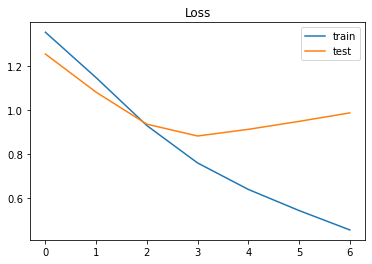

In [48]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

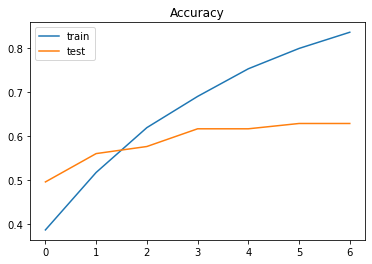

In [49]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

# Results:
### * Multinomial naive bayes Accuracy: 71.84%
### * Logistic Regression Accuracy: 75.00%
### * Support Vector Machine Accuracy: 74.75%
### * Voting Classifier Accuracy: 75.00%
### * LSTM Accuracy: 65.00%

If you find this notebook useful, please upvote it!